In [5]:
import os
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from keras.models import Model, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten, Dense, Dropout

## Load pretrained model
1. load pretrained model
2. load local weights
3. frezee its layers

In [11]:
local_weights_file = "./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"


In [12]:
pretrained_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights=None)

In [13]:
pretrained_model.weights

[<tf.Variable 'conv2d_94/kernel:0' shape=(3, 3, 3, 32) dtype=float32, numpy=
 array([[[[ 1.17440358e-01, -1.16611049e-01, -1.20218992e-02,
            5.54118305e-02, -5.61316907e-02, -4.38375026e-02,
            7.56480098e-02, -3.53852957e-02,  1.30200371e-01,
           -2.78072655e-02,  6.47689253e-02, -7.39864111e-02,
           -1.34375438e-01,  9.36517566e-02, -1.37786821e-01,
           -6.66838288e-02, -4.82702851e-02, -1.10198855e-02,
           -1.12204060e-01, -8.01860243e-02,  6.56046569e-02,
           -1.22324482e-01, -1.09677851e-01, -7.39870742e-02,
            8.57607722e-02,  7.38600194e-02,  8.09815526e-03,
           -4.42118645e-02, -1.05181992e-01, -1.73378810e-02,
            4.80303466e-02,  6.32096827e-03],
          [ 1.24079093e-01, -6.91562742e-02, -1.03034750e-01,
           -1.93515942e-02,  3.81706655e-03, -1.12529755e-01,
           -1.02668911e-01, -4.71615791e-03,  6.81407005e-02,
            4.39552665e-02,  1.21095464e-01, -6.97784051e-02,
         

In [14]:
pretrained_model.load_weights(local_weights_file)

In [15]:
# frezee its layers
for layer in pretrained_model.layers:
    layer.trainable = False

In [17]:
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                       

In [18]:
last_layer = pretrained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


## add Dense layer to classifier

In [20]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
from keras.layers import Dense, Flatten

x = Flatten()(last_output)
x = Dense(1024)(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=pretrained_model.input, outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [22]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [32]:
# Define our example directories and files
base_dir = '../Week_1/cats_and_dogs_filtered/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [33]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary',
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [34]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 51s - loss: 0.7447 - accuracy: 0.8620 - val_loss: 0.2922 - val_accuracy: 0.9400 - 51s/epoch - 506ms/step
Epoch 2/20
100/100 - 39s - loss: 0.5823 - accuracy: 0.8890 - val_loss: 0.2254 - val_accuracy: 0.9530 - 39s/epoch - 389ms/step
Epoch 3/20
100/100 - 38s - loss: 0.4731 - accuracy: 0.9050 - val_loss: 0.2306 - val_accuracy: 0.9540 - 38s/epoch - 378ms/step
Epoch 4/20
100/100 - 39s - loss: 0.3968 - accuracy: 0.9210 - val_loss: 0.3706 - val_accuracy: 0.9380 - 39s/epoch - 386ms/step
Epoch 5/20
100/100 - 38s - loss: 0.4040 - accuracy: 0.9200 - val_loss: 0.1727 - val_accuracy: 0.9630 - 38s/epoch - 381ms/step
Epoch 6/20
100/100 - 39s - loss: 0.3431 - accuracy: 0.9335 - val_loss: 0.2817 - val_accuracy: 0.9540 - 39s/epoch - 392ms/step
Epoch 7/20
100/100 - 39s - loss: 0.3569 - accuracy: 0.9310 - val_loss: 0.3241 - val_accuracy: 0.9400 - 39s/epoch - 394ms/step
Epoch 8/20
100/100 - 39s - loss: 0.3404 - accuracy: 0.9265 - val_loss: 0.1882 - val_accuracy: 0.9670 - 39s/epoch - 395

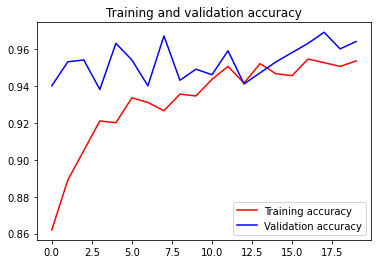

<Figure size 432x288 with 0 Axes>

In [35]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()